<a href="https://colab.research.google.com/github/nasrullahasghar/lung-cancer-detection/blob/main/Lung_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **01 Data Loading and Preprocessing**

In [ ]:

train_folder = '/content/drive/MyDrive/Data/train'
test_folder = '/content/drive/MyDrive/Data/test'
validate_folder = '/content/drive/MyDrive/Data/valid'

normal_folder = '/normal'
adenocarcinoma_folder = '/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
large_cell_carcinoma_folder = '/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
squamous_cell_carcinoma_folder = '/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils

In [ ]:
# Read data from the folders
IMAGE_SIZE = (350, 350)

print("Reading training images from:", train_folder)
print("Reading validation images from:", validate_folder)

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 8

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)


Reading training images from: /content/drive/MyDrive/Data/train
Reading validation images from: /content/drive/MyDrive/Data/valid
Found 617 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.5, min_lr=0.000001)
early_stops = EarlyStopping(monitor='loss', min_delta=0, patience=6, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(filepath='best_model.weights.h5', verbose=2, save_best_only=True, save_weights_only=True)

In [ ]:
OUTPUT_SIZE = 4

pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

model = Sequential()
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(OUTPUT_SIZE, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=50,
    callbacks=[learning_rate_reduction, early_stops, checkpointer],
    validation_data=validation_generator,
    validation_steps=20
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2984 - loss: 1.4178
Epoch 1: val_loss improved from inf to 1.22292, saving model to best_model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 276s 9s/step - accuracy: 0.3012 - loss: 1.4142 - val_accuracy: 0.4500 - val_loss: 1.2229 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5509 - loss: 1.1084
Epoch 2: val_loss improved from 1.22292 to 1.10068, saving model to best_model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.5503 - loss: 1.1069 - val_accuracy: 0.5226 - val_loss: 1.1007 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6255 - loss: 0.9878 - learning_rate: 0.0010
Epoch 4/50
 3/25 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.5764 - loss: 0.9218 
Epoch 4: val_loss improved from 1.10068 to 0.99046, saving model to best_model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6558 - loss: 0.8699 - val_accuracy: 0.493

In [ ]:
print("Final training accuracy =", history.history['accuracy'][-1])
print("Final testing accuracy =", history.history['val_accuracy'][-1])

Final training accuracy = 0.8899999856948853
Final testing accuracy = 0.6580645442008972


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
accuracy = accuracy_score(true_classes, predicted_classes)

NameError: name 'true_classes' is not defined

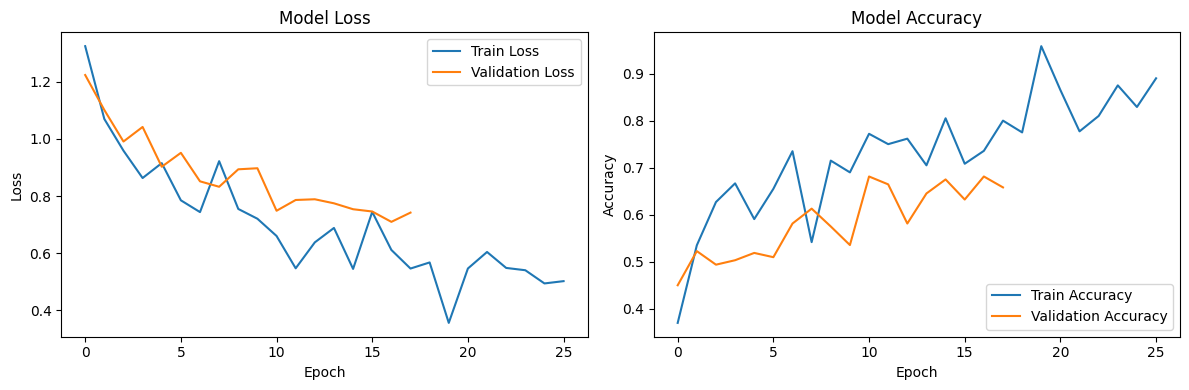

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

In [ ]:
model.save('/content/drive/MyDrive/dataset/trained_lung_cancer_model.h5')